In [1]:
import numpy as np
from TMDP import TMDP
from River_swim import River

from algorithms import *
from model_functions import *
import matplotlib as mpl
import matplotlib.pyplot as plt

np.set_printoptions(precision=4)
import math
from utils import *
import itertools



In [2]:
# Test with tau=0.9
nS = 8
nA = 2
seed = 3231
status_step = 500
gamma = 0.9
river = River(nS, gamma, 5, 1000)
tau = 0.3
xi = np.ones(river.nS)*1/river.nS
tmdp = TMDP(river, xi, tau, gamma, seed)
tmdp_0 = TMDP(river, xi, 0, gamma, seed)
tmdp_1 = TMDP(river, xi, 0.02, gamma, seed)

colors = itertools.cycle(["r", "b"])

In [3]:
# Optimal Q function
r_s_a = compute_r_s_a(tmdp.nS, tmdp.nA, tmdp.P_mat, tmdp.reward)
Q_star = bellman_optimal_q(tmdp.nS, tmdp.nA, tmdp.P_mat, tmdp.reward, 1e-4, gamma)
J_star = get_expected_avg_reward(tmdp.P_mat, get_policy(Q_star), tmdp.reward, tmdp.gamma, tmdp.mu)
delta_q = np.linalg.norm(Q_star - Q_star, np.inf)

In [4]:
#taus = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
results = []
intermediate_results = {}
curr_j = []
delta_qs = []

Q = np.zeros((tmdp.nS, tmdp.nA))
M = 200000

s = tmdp.reset()
a = eps_greedy(s, Q, 1., tmdp.allowed_actions[int(s)])

Q, J_main_p, J_curr_p, inner_delta_qs, _, _ = Q_learning(tmdp, s, a, Q, Q_star, M=M, alpha=0.04, debug=True, status_step=status_step)
intermediate_results['tau_'+str(tau)] = {'J': J_main_p, "delta_q":inner_delta_qs}
delta_q = np.linalg.norm(Q_star - Q, np.inf)

# Test the policy extracted from Q on the original problem
J = get_expected_avg_reward(tmdp.P_mat, get_policy(Q), tmdp.reward, tmdp.gamma, tmdp.mu)

results.append({"type":"scratch", "Q": Q, "tau":"{:.2f}".format(tau), "J":J, "policy":get_policy(Q),"delta_q":delta_q})

In [5]:

Q_1 = np.zeros((tmdp_1.nS, tmdp_1.nA))
M = 200000

s = tmdp_1.reset()
a = eps_greedy(s, Q_1, 1., tmdp_1.allowed_actions[int(s)])

Q_1, J_main_p, J_curr_p, inner_delta_qs, _, _ = Q_learning(tmdp_1, s, a, Q_1, Q_star, M=M, alpha=0.04, debug=True, status_step=status_step)
intermediate_results['tau_'+str(tmdp_1.tau)] = {'J': J_main_p, "delta_q":inner_delta_qs}
delta_q = np.linalg.norm(Q_star - Q_1, np.inf)

# Test the policy extracted from Q on the original problem
J = get_expected_avg_reward(tmdp_1.P_mat, get_policy(Q_1), tmdp_1.reward, tmdp_1.gamma, tmdp_1.mu)

results.append({"type":"scratch", "Q": Q_1, "tau":"{:.2f}".format(tmdp_1.tau), "J":J, "policy":get_policy(Q_1),"delta_q":delta_q})

In [6]:
Q_0 = Q 
#Q_0 = np.zeros((tmdp_0.nS, tmdp_0.nA))
M = 200000

s = tmdp_0.reset()
a = eps_greedy(s, Q_0, 1., tmdp_0.allowed_actions[int(s)])

Q_0, J_main_p, J_curr_p, inner_delta_qs, _, _ = Q_learning(tmdp_0, s, a, Q_0, Q_star, M=M, alpha=0.04, debug=True, status_step=status_step)
intermediate_results['tau_'+str(tmdp_0.tau)] = {'J': J_main_p, "delta_q":inner_delta_qs}
delta_q = np.linalg.norm(Q_star - Q_0, np.inf)

# Test the policy extracted from Q on the original problem
J = get_expected_avg_reward(tmdp_0.P_mat, get_policy(Q_0), tmdp_0.reward, tmdp_0.gamma, tmdp_0.mu)

results.append({"type":"scratch", "Q": Q_0, "tau":"{:.2f}".format(tau), "J":J, "policy":get_policy(Q_0),"delta_q":delta_q})

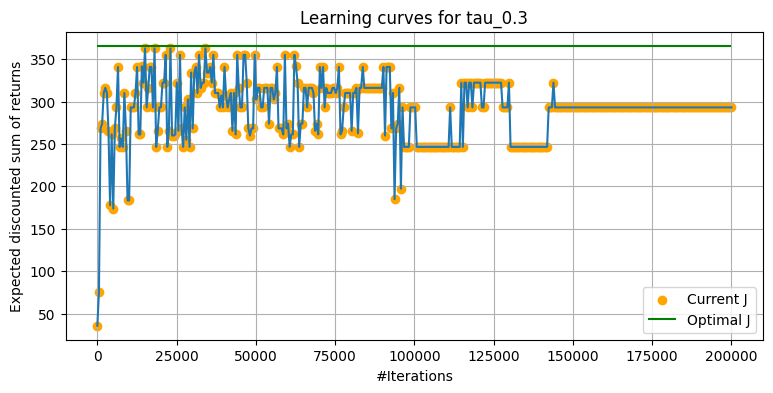

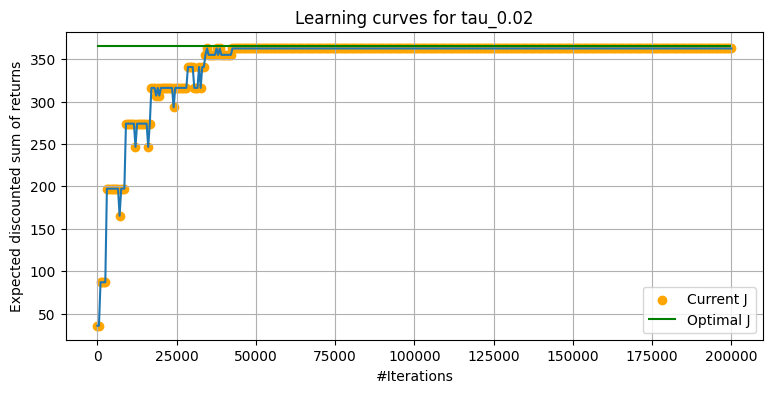

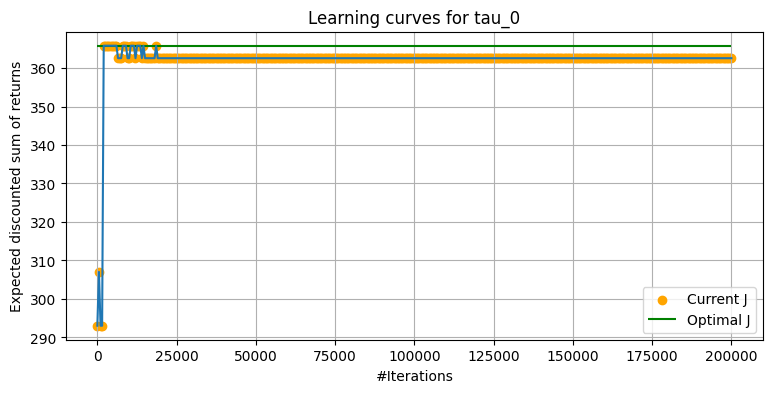

In [7]:
for i, key in enumerate(intermediate_results.keys()):
    xmax = len(intermediate_results[key]['J'])*status_step
    x = np.linspace(0, xmax, num=len(intermediate_results[key]['J']))
    y = intermediate_results[key]['J']
    plt.figure(fignS=(9, 4))
    plt.scatter(x, y, c='orange', label='Current J')
    plt.hlines(y=J_star, xmin=0, xmax=xmax, colors=['green'], label='Optimal J')
    plt.plot(x, y)
    plt.grid(visible=True)
    plt.legend(loc="lower right")
    plt.xlabel('#Iterations')
    plt.ylabel('Expected discounted sum of returns')
    plt.title('Learning curves for '+str(key))

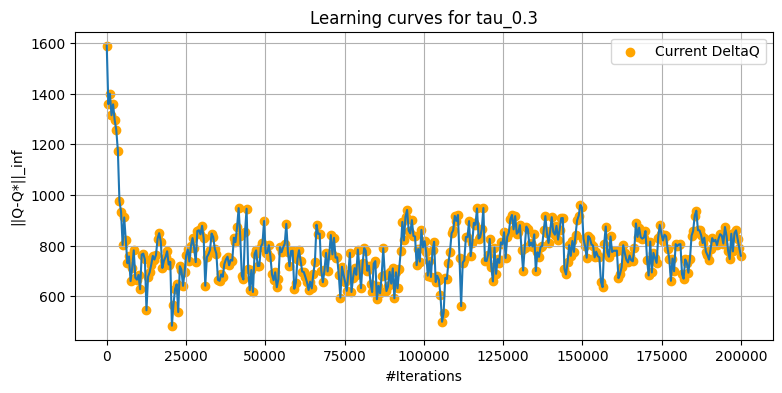

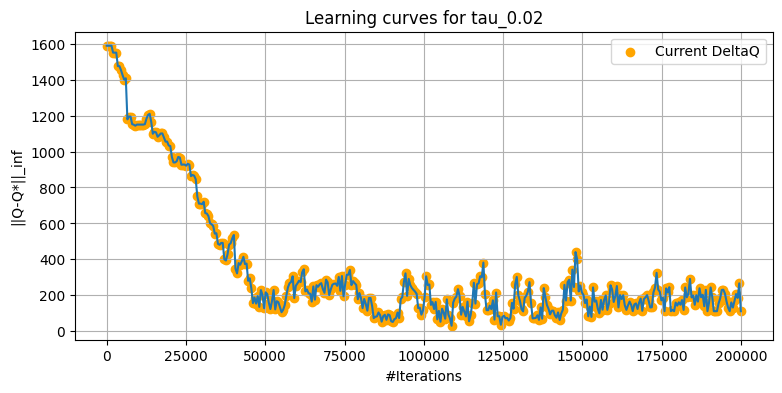

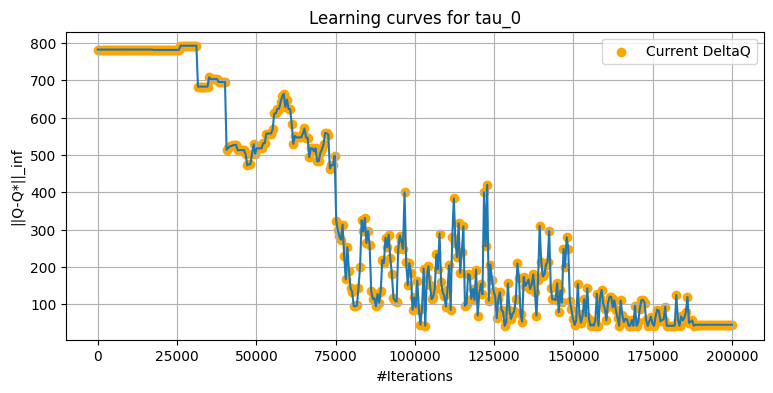

In [8]:
for i, key in enumerate(intermediate_results.keys()):
    xmax = len(intermediate_results[key]['delta_q'])*status_step
    x = np.linspace(0, xmax, num=len(intermediate_results[key]['delta_q']))
    y = intermediate_results[key]['delta_q']
    plt.figure(fignS=(9, 4))
    plt.scatter(x, y, c='orange', label='Current DeltaQ')
    plt.plot(x, y)
    plt.legend(loc="upper right")
    plt.xlabel('#Iterations')
    plt.ylabel('||Q-Q*||_inf')
    plt.grid(visible=True)
    plt.title('Learning curves for '+str(key))

In [9]:
# Veryfying the expected value of the difference among the two transition models
z = 2*(abs(tmdp.tau - tmdp_0.tau))
for i in range(tmdp.P_mat_tau.shape[0]):
    x = np.linalg.norm(tmdp.P_mat_tau[i] - tmdp_0.P_mat_tau[i], 1)
    print("Expected difference among the two transition models {}. Theoretical Upperbound {}".format(x, z))

get_expected_difference_transition_models(tmdp.P_mat_tau, tmdp.P_mat)

get_sup_difference_transition_models(tmdp.P_mat_tau, tmdp.P_mat)

Expected difference among the two transition models 0.525. Theoretical Upperbound 0.6
Expected difference among the two transition models 0.44999999999999996. Theoretical Upperbound 0.6
Expected difference among the two transition models 0.525. Theoretical Upperbound 0.6
Expected difference among the two transition models 0.39. Theoretical Upperbound 0.6
Expected difference among the two transition models 0.525. Theoretical Upperbound 0.6
Expected difference among the two transition models 0.39. Theoretical Upperbound 0.6
Expected difference among the two transition models 0.525. Theoretical Upperbound 0.6
Expected difference among the two transition models 0.38999999999999996. Theoretical Upperbound 0.6
Expected difference among the two transition models 0.525. Theoretical Upperbound 0.6
Expected difference among the two transition models 0.39. Theoretical Upperbound 0.6
Expected difference among the two transition models 0.525. Theoretical Upperbound 0.6
Expected difference among the

0.525

In [10]:
# Veryfing the L_1 norm of the difference among the gamma discounted state distributions
d_0 = compute_d(tmdp_0.mu, tmdp_0.P_mat_tau, get_policy(Q_star), tmdp_0.gamma)
delta_0 = compute_delta(d_0, get_policy(Q_star))

d = compute_d(tmdp.mu, tmdp.P_mat_tau, get_policy(Q), tmdp.gamma)
delta = compute_delta(d, get_policy(Q))

d_1 = compute_d(tmdp_1.mu, tmdp_1.P_mat_tau, get_policy(Q_1), tmdp_1.gamma)
delta_1 = compute_delta(d_1, get_policy(Q_1))

print(d_0)
print(delta_0)

print(d)
print(delta)

print(d_1)
print(delta_1)

z = 2*(abs(tmdp.tau - tmdp_1.tau))
d_1_d = np.linalg.norm(d_1 - d, 1)
upp_bound_d = tmdp.gamma*z/(1-tmdp.gamma)

print("Expected difference among the two gamma discounted state distributions {}. Theoretical Upperbound {}".format(d_1_d, upp_bound_d))


[0.0522 0.0759 0.0921 0.1044 0.1182 0.152  0.2834 0.1219]
[[0.     0.0522]
 [0.     0.0759]
 [0.     0.0921]
 [0.     0.1044]
 [0.     0.1182]
 [0.     0.152 ]
 [0.     0.2834]
 [0.     0.1219]]
[0.1396 0.0858 0.1127 0.1212 0.1244 0.1309 0.1852 0.1002]
[[0.1396 0.    ]
 [0.     0.0858]
 [0.     0.1127]
 [0.     0.1212]
 [0.     0.1244]
 [0.     0.1309]
 [0.     0.1852]
 [0.     0.1002]]
[0.1588 0.0453 0.0744 0.0939 0.1108 0.1424 0.2607 0.1138]
[[0.1588 0.    ]
 [0.     0.0453]
 [0.     0.0744]
 [0.     0.0939]
 [0.     0.1108]
 [0.     0.1424]
 [0.     0.2607]
 [0.     0.1138]]
Expected difference among the two gamma discounted state distributions 0.23975296854854783. Theoretical Upperbound 5.040000000000001


## 1-step transfer learning test. From tau to original problem

In [11]:
taus = [0.9, 0.7, 0.6, 0.4, 0.2, 0.09, 0.07, 0.05, 0.04, 0.02, 0.01]
results = []
intermediate_results = {}
curr_j = []
delta_qs = []
status_step = 500
tmdp_0 = TMDP(river, xi, 0, gamma)
# Learning from scratch with different values of tau
for tau in taus:
    tmdp = TMDP(river, xi, tau, gamma)
    Q = np.zeros((tmdp.nS, tmdp.nA))
    M = 200000
    
    s = tmdp.reset()
    a = eps_greedy(s, Q, 1., tmdp.allowed_actions[int(s)])
    
    Q, inner_main_J, inner_curr_J, inner_delta_qs, inner_delta_J, inner_l_bounds = Q_learning(tmdp, s, a, Q, Q_star, M=M, alpha=0.03, debug=True, status_step=status_step, main_p=False)
    
    intermediate_results['tau_'+str(tau)] = {'J_main_p': inner_main_J,"J_curr_p":inner_curr_J, "delta_q":inner_delta_qs, 'Q':Q, "tmdp":tmdp, "delta_J":inner_delta_J, "l_bounds": inner_l_bounds}
    delta_q = np.linalg.norm(Q_star - Q, np.inf)
    
    J = get_expected_avg_reward(tmdp.P_mat, get_policy(Q), tmdp.reward, tmdp.gamma, tmdp.mu)
    results.append({"type":"scratch", "Q": Q, "tau":"{:.2f}".format(tau), "J":J, "policy":get_policy(Q),"delta_q":delta_q, "tmdp":tmdp})

    s = tmdp_0.reset()
    a = eps_greedy(s, Q, 1., tmdp_0.allowed_actions[int(s)])
    Q, inner_main_J, inner_curr_J, inner_delta_qs, _, _ = Q_learning(tmdp_0, s, a, Q, Q_star, M=M, alpha=0.03, debug=True, status_step=status_step)
    intermediate_results['transfer_'+str(tau)] = {'J_main_p': inner_main_J,"J_curr_p":inner_curr_J, "delta_q":inner_delta_qs, 'Q':Q, "tmdp":tmdp_0}
    delta_q = np.linalg.norm(Q_star - Q, np.inf)

    J = get_expected_avg_reward(tmdp_0.P_mat, get_policy(Q), tmdp_0.reward, tmdp_0.gamma, tmdp_0.mu)
    results.append({"type":"transfer", "Q": Q, "tau":"{:.2f}".format(tau), "J":J, "policy":get_policy(Q),"delta_q":delta_q, "tmdp":tmdp_0})

In [12]:
agg_res = aggregate_results(results, len(results))

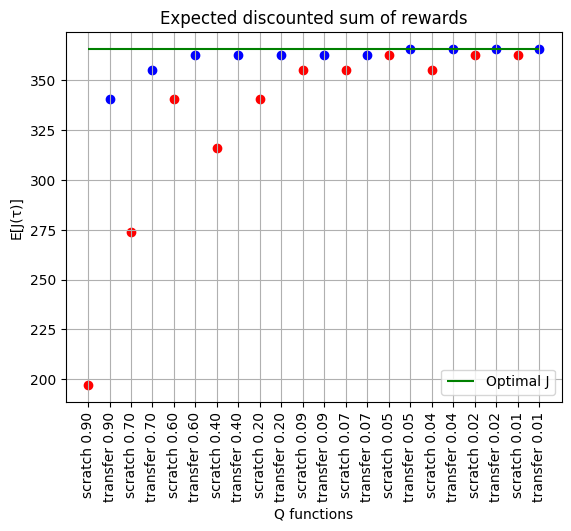

In [13]:
x = np.array([])
y = np.array([])
ci = np.array([])
for res in agg_res:
    yi =res['avg_J']
    y = np.append(y, yi)
    label = res['type'] + " " + str(res['tau'])
    x = np.append(x, label)
    ci = np.append(ci, res['ci_J'])
    plt.scatter(label, yi, c=next(colors))
x_map = np.array([i for i in range(len(x))])
offset = np.array([0.25 if ci[i] > 0.001 else 0 for i in range(len(x))])
#fig, ax = plt.subplots(fignS=(5, 2.7), layout='constrained')

plt.xticks(x_map, x)
#plt.plot(x, y)
#plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
plt.hlines(y=y-ci, xmin=x_map-offset, xmax=x_map + offset)
plt.hlines(y=y+ci, xmin=x_map-offset, xmax=x_map + offset)
plt.hlines(y=J_star, xmin=0, xmax=len(x)-1, colors=['green'], label='Optimal J')
plt.vlines(x, ymin = y-ci, ymax = y+ci)
plt.xlabel("Q functions")
plt.xticks(rotation=90)
plt.ylabel("E[J(τ)]")
plt.title("Expected discounted sum of rewards")
plt.grid(visible=True)
plt.legend(loc="lower right")

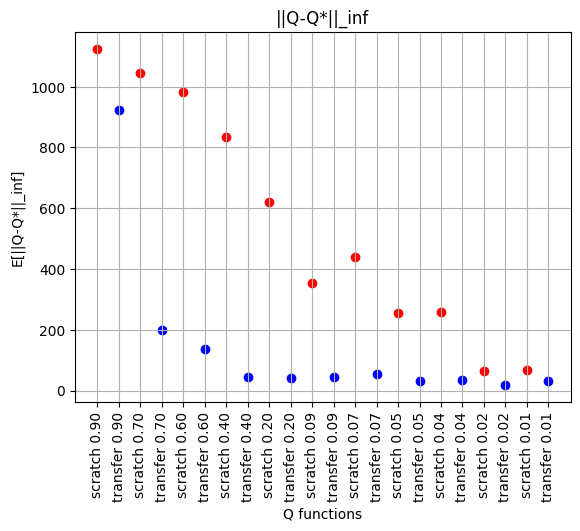

In [14]:
x = np.array([])
y = np.array([])
ci = np.array([])
for res in agg_res:
    yi = res['avg_delta_q']
    y = np.append(y, yi)
    label = res['type'] + " " + str(res['tau']) 
    x = np.append(x, label)
    ci = np.append(ci, res['ci_delta_q'])
    plt.scatter(label, yi, c=next(colors))
offset = np.array([0.25 if ci[i] > 0.001 else 0 for i in range(len(x))])
#fig, ax = plt.subplots(fignS=(5, 2.7), layout='constrained')
#plt.scatter(x, y, c='orange')

plt.xticks(x_map, x)
#plt.plot(x, y)
#plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
plt.hlines(y=y-ci, xmin=x_map-offset, xmax=x_map + offset)
plt.hlines(y=y+ci, xmin=x_map-offset, xmax=x_map + offset)
plt.vlines(x, ymin = y-ci, ymax = y+ci)
plt.xlabel("Q functions")
plt.xticks(rotation=90)
plt.ylabel('E[||Q-Q*||_inf]')
plt.title("||Q-Q*||_inf")
plt.grid(visible=True)

C:\Users\crist\AppData\Local\Temp\ipykernel_14100\711591137.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(fignS=(9, 4))


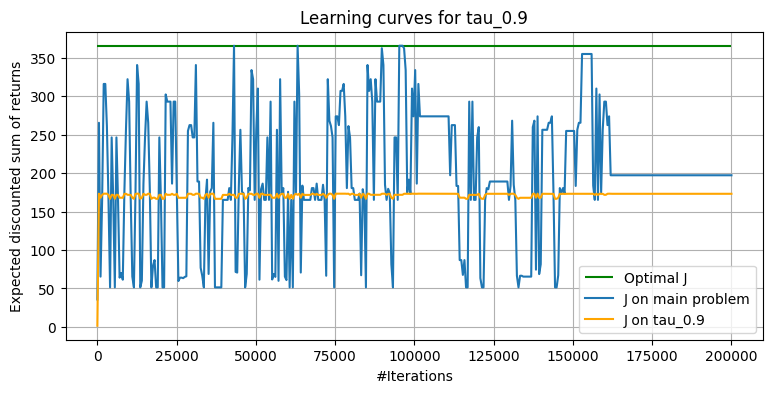

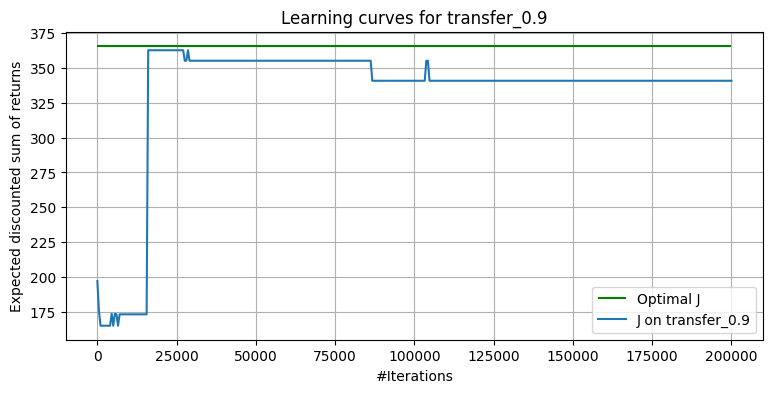

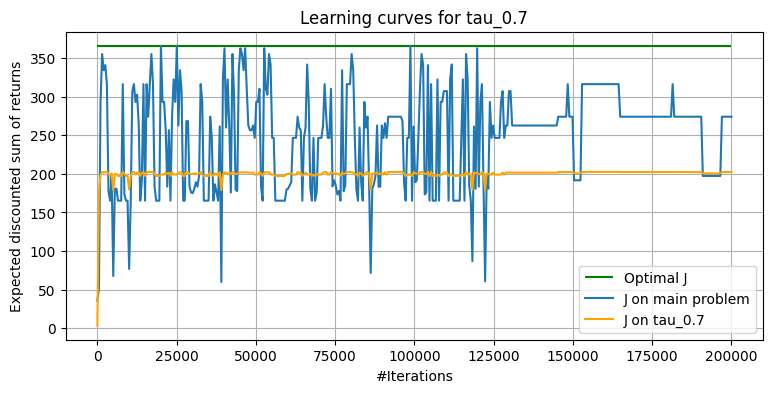

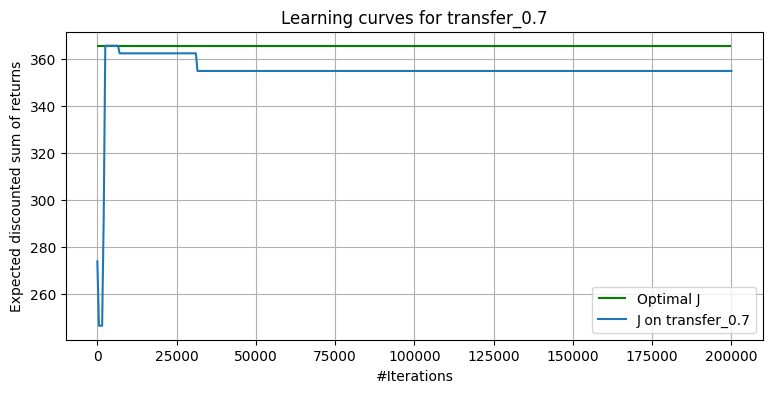

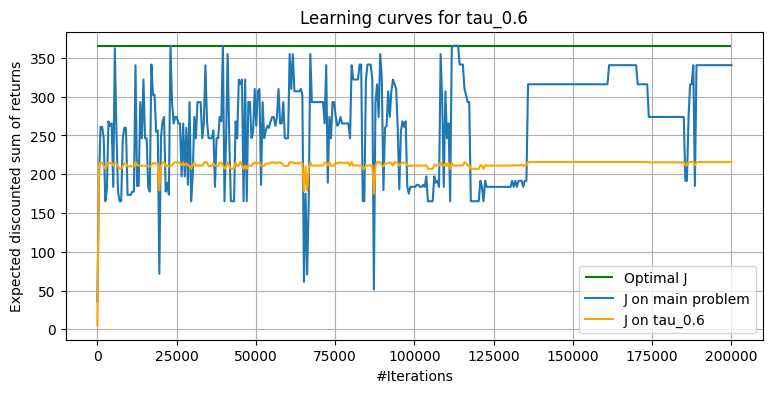

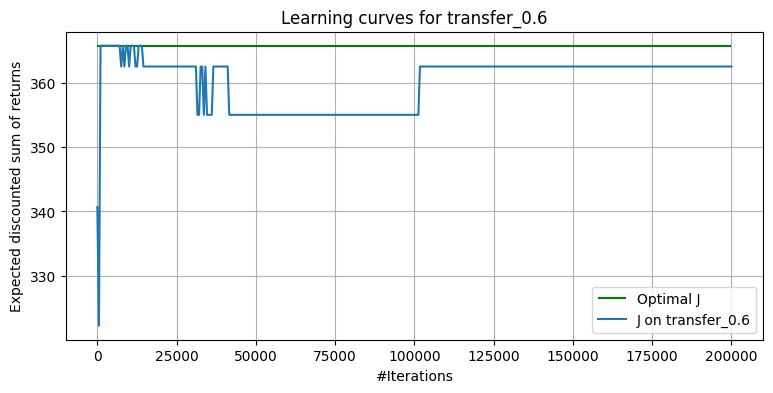

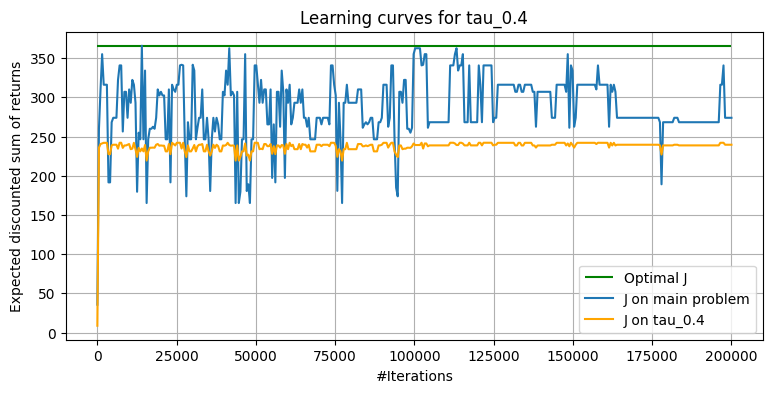

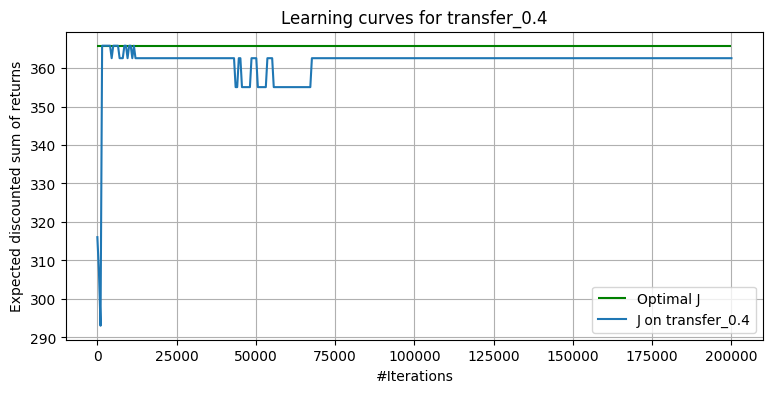

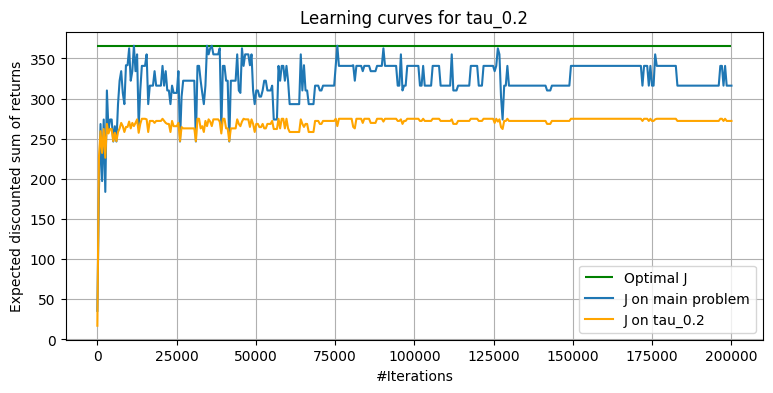

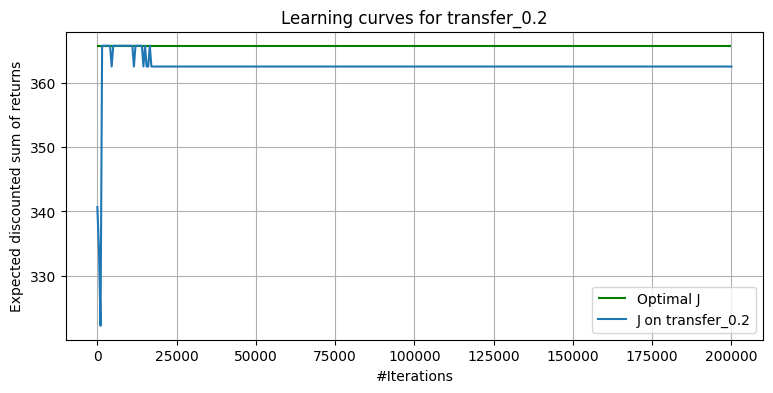

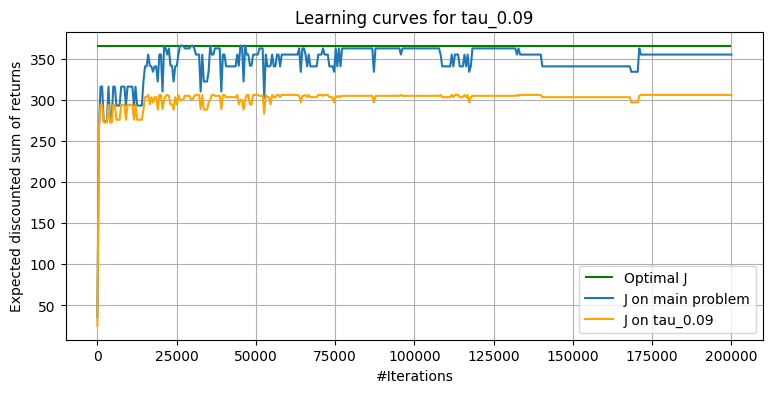

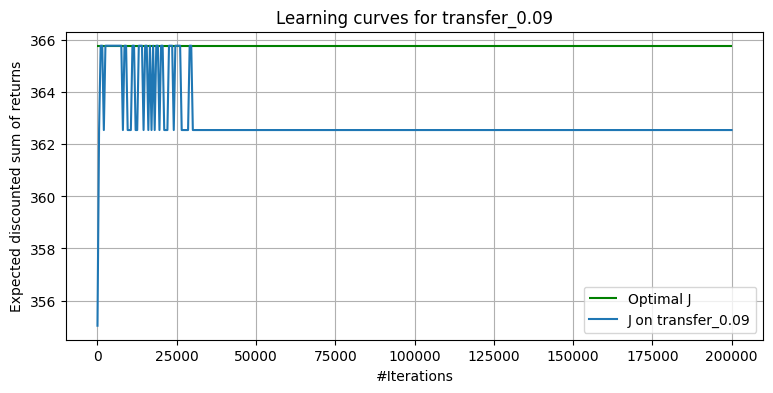

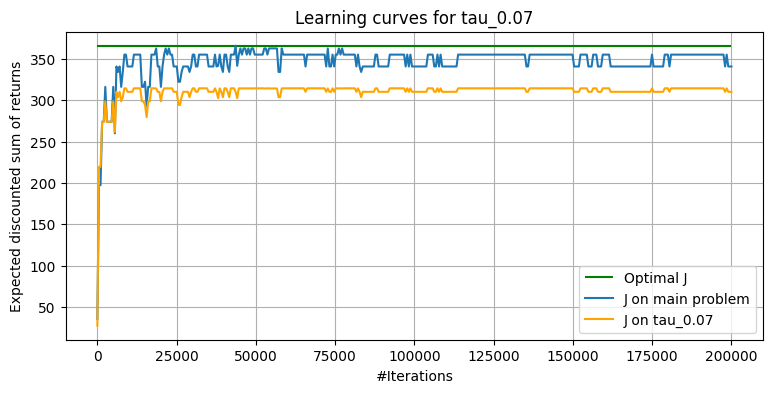

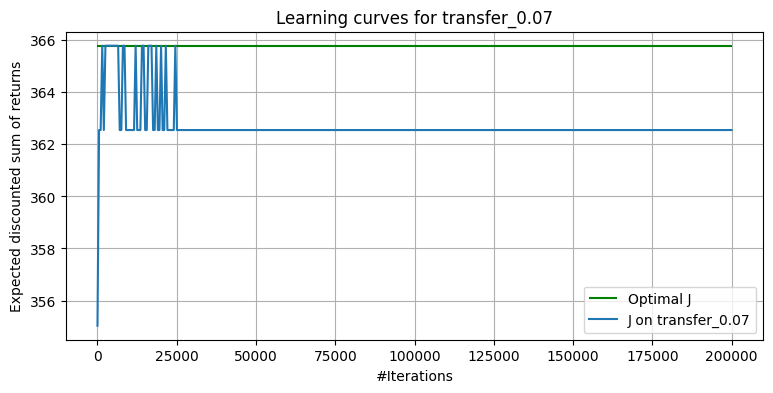

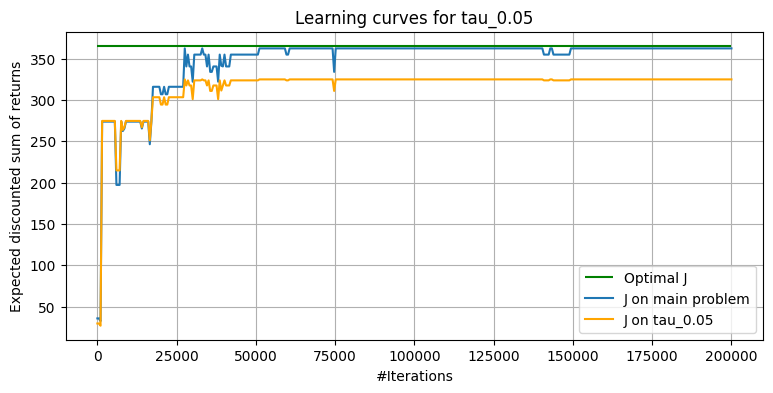

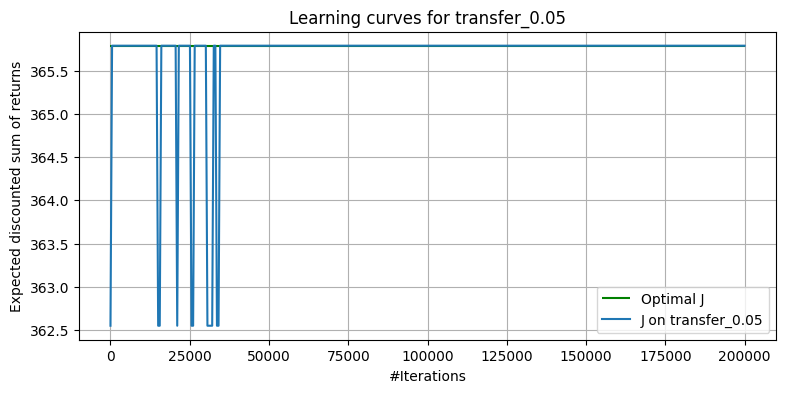

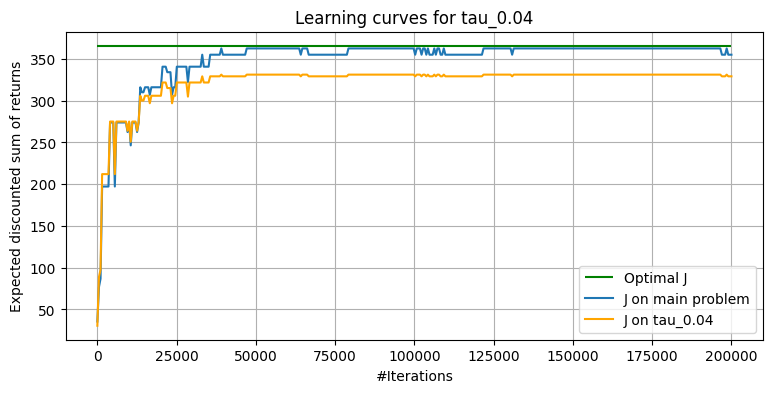

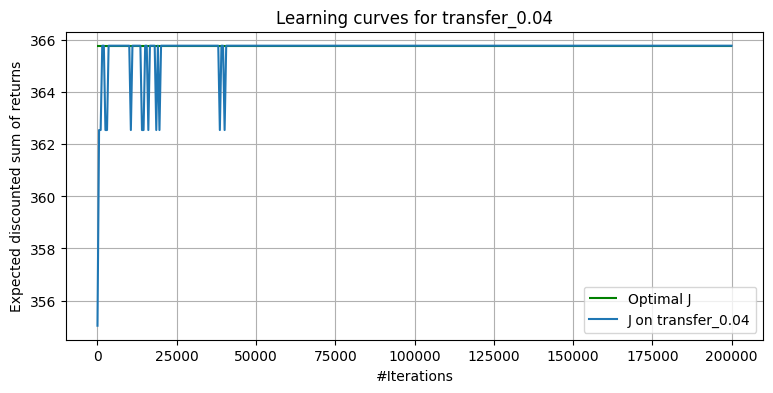

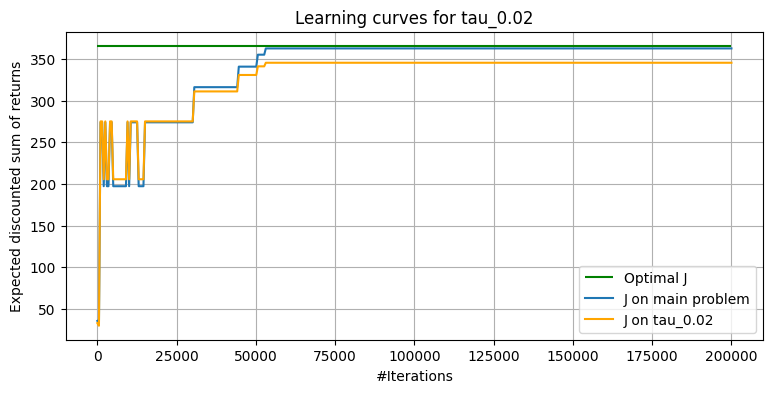

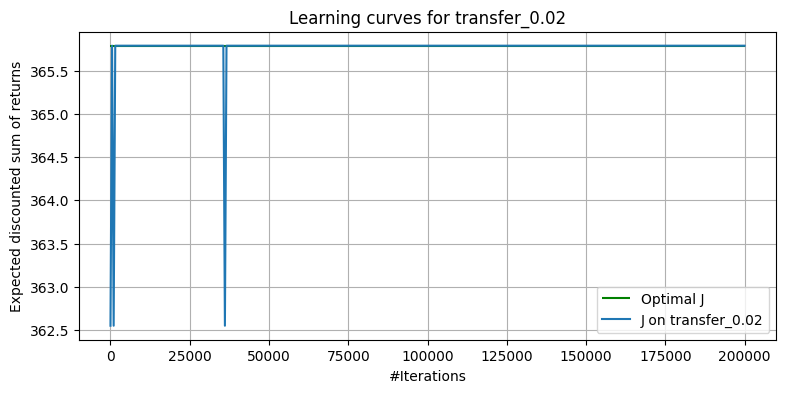

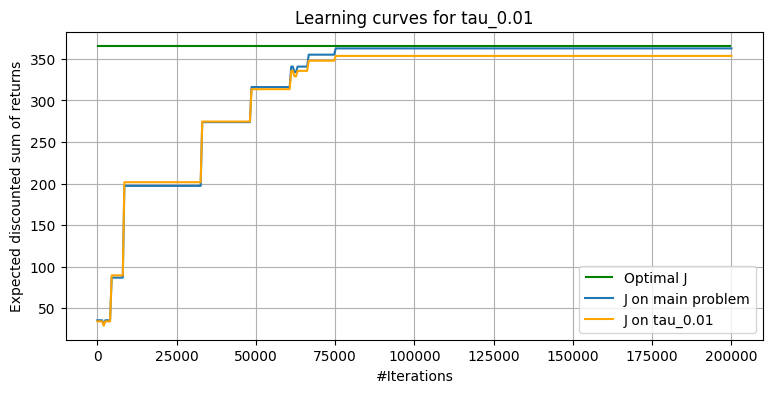

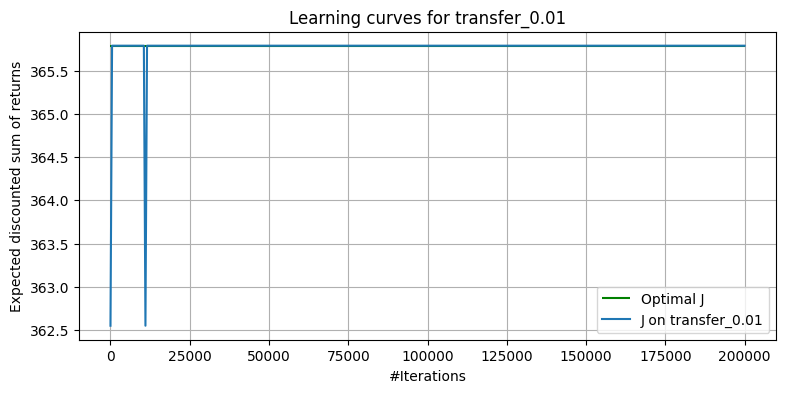

In [15]:
for i, key in enumerate(intermediate_results.keys()):
    xmax = len(intermediate_results[key]['J_main_p'])*status_step
    x = np.linspace(0, xmax, num=len(intermediate_results[key]['J_main_p']))
    y = intermediate_results[key]['J_main_p']
    z = intermediate_results[key]['J_curr_p']
    plt.figure(fignS=(9, 4))
    #plt.scatter(x, y, c='orange', label='Current J')
    plt.hlines(y=J_star, xmin=0, xmax=xmax, colors=['green'], label='Optimal J')
    if "tau_" in key:
        plt.plot(x, y, label='J on main problem')
        plt.plot(x, z, label='J on '+str(key), c='orange')
    else:
         plt.plot(x, y, label='J on '+str(key))
    plt.grid(visible=True)
    plt.legend(loc="lower right")
    plt.xlabel('#Iterations')
    plt.ylabel('Expected discounted sum of returns')
    plt.title('Learning curves for '+str(key))

C:\Users\crist\AppData\Local\Temp\ipykernel_14100\2599771843.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(fignS=(9, 4))


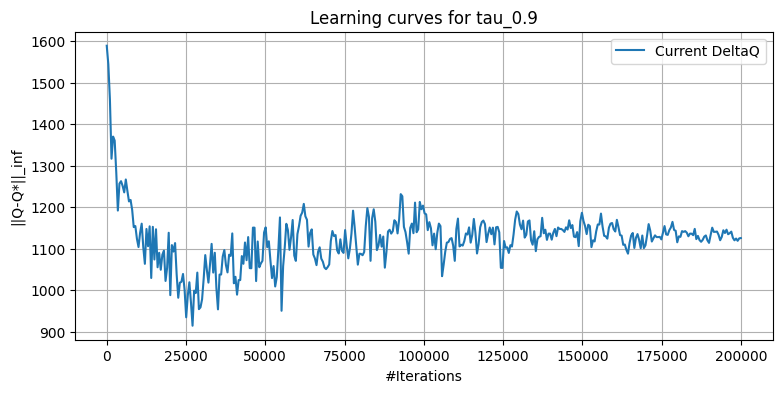

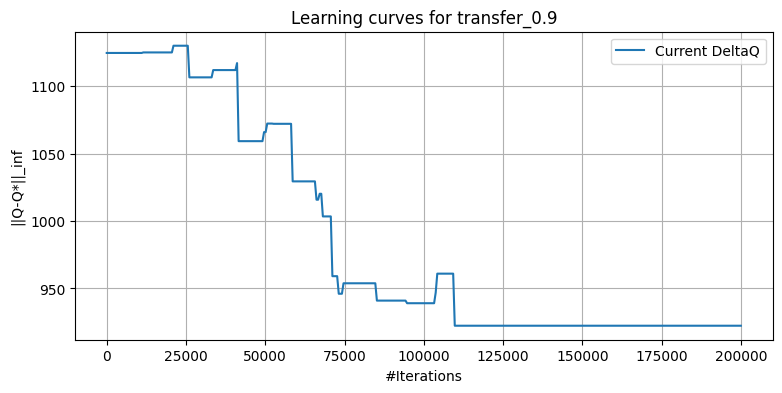

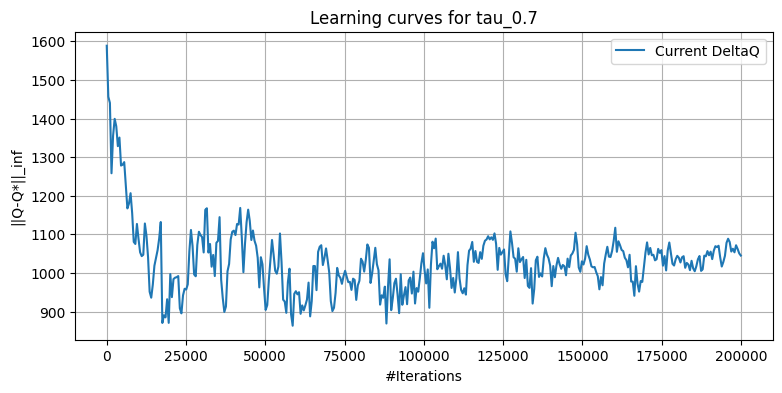

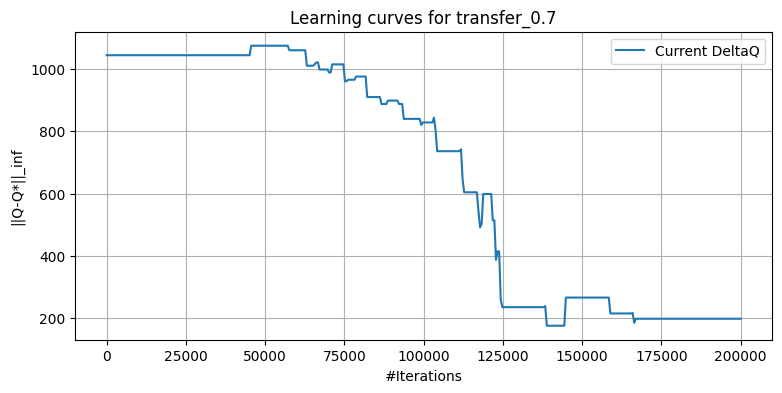

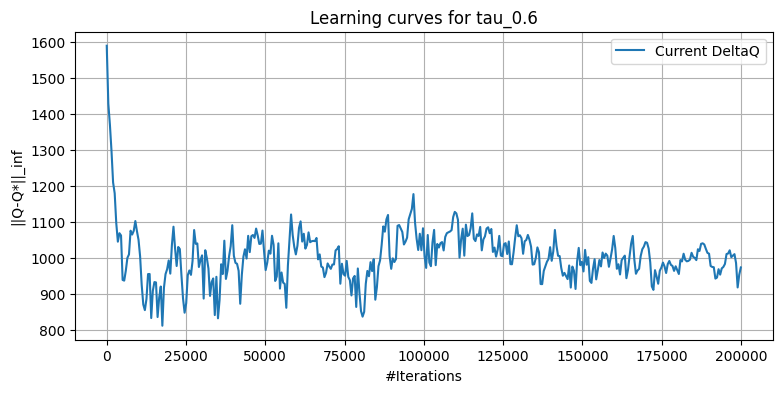

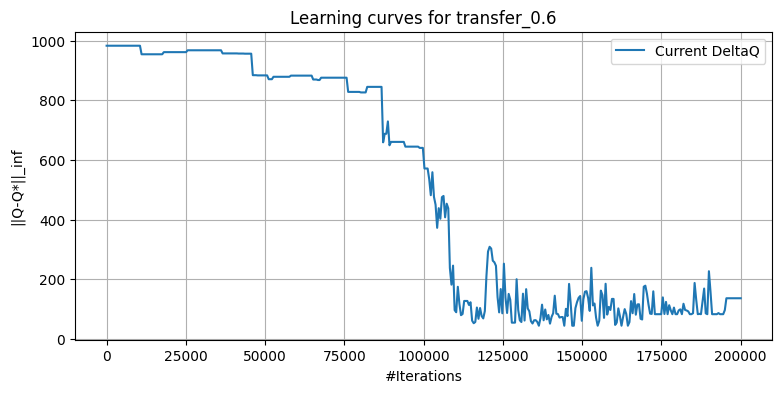

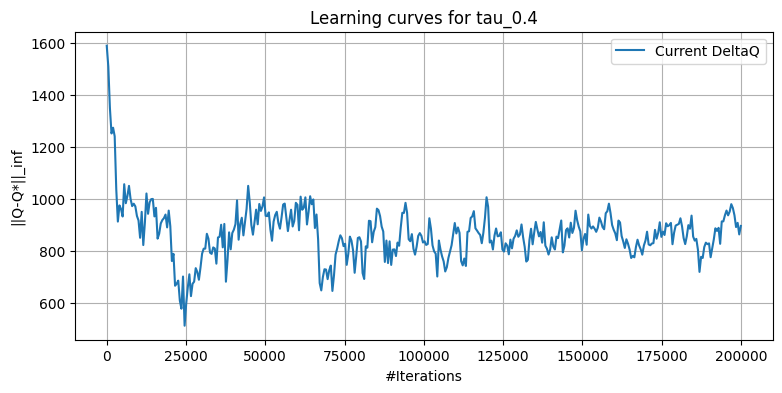

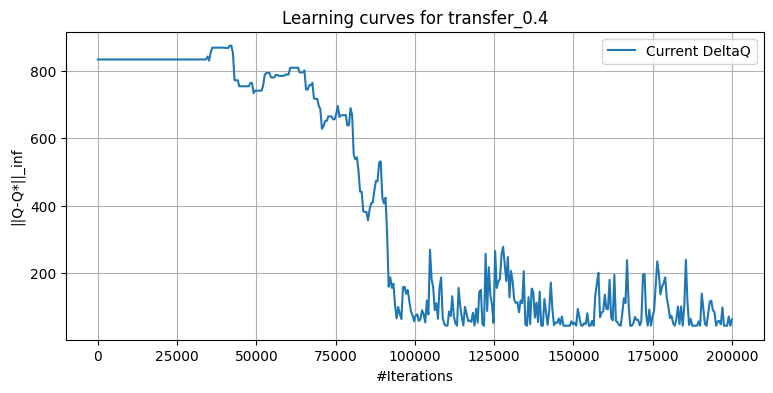

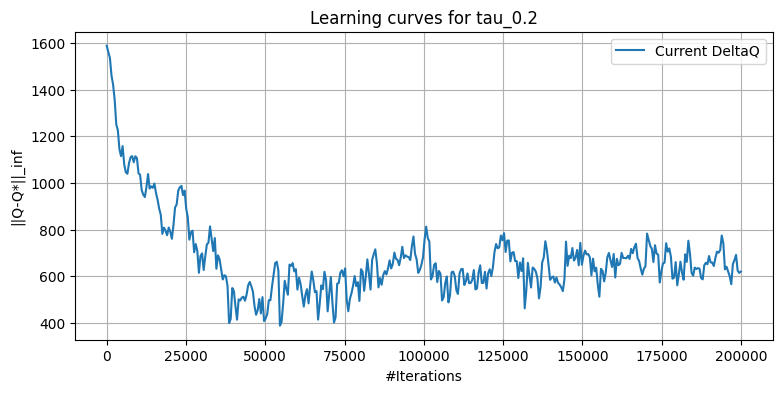

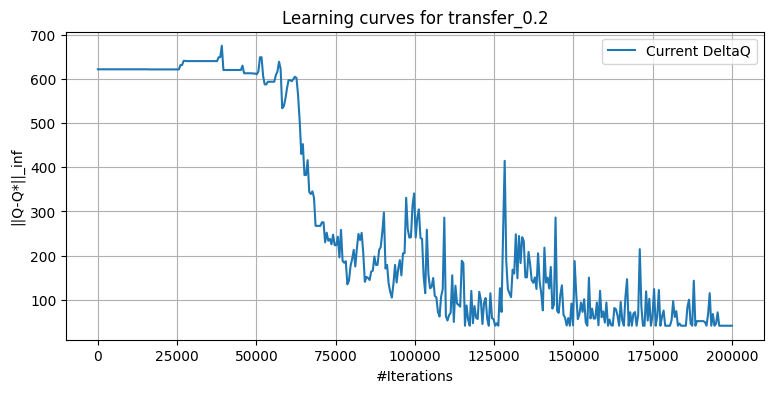

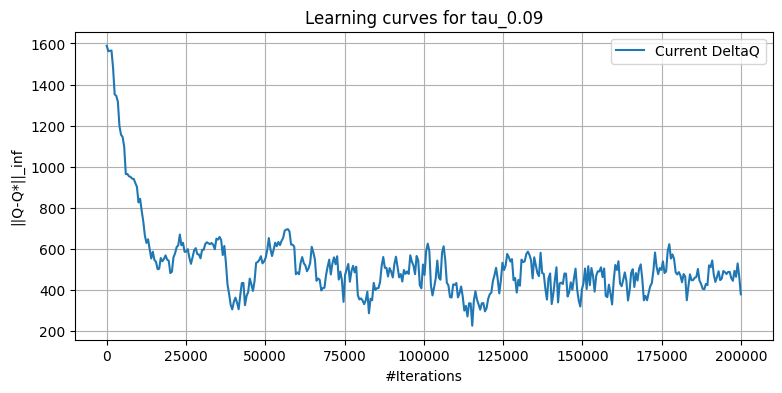

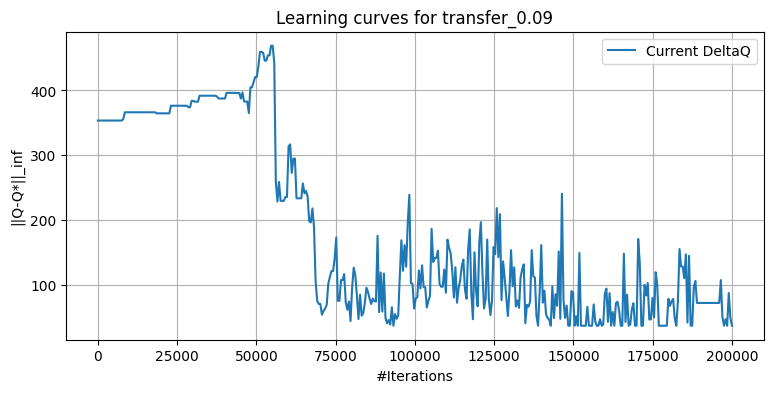

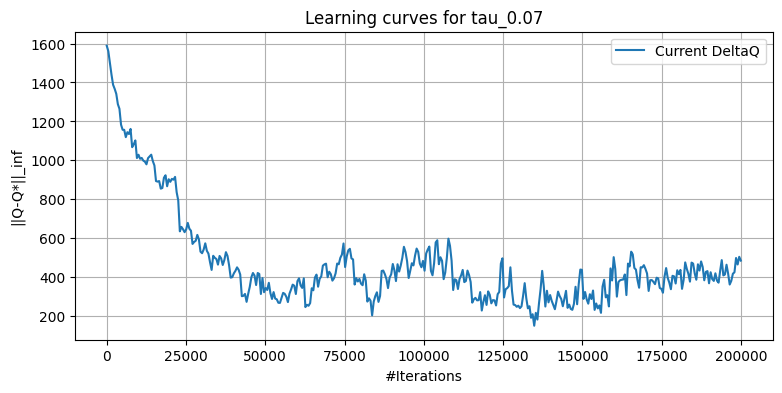

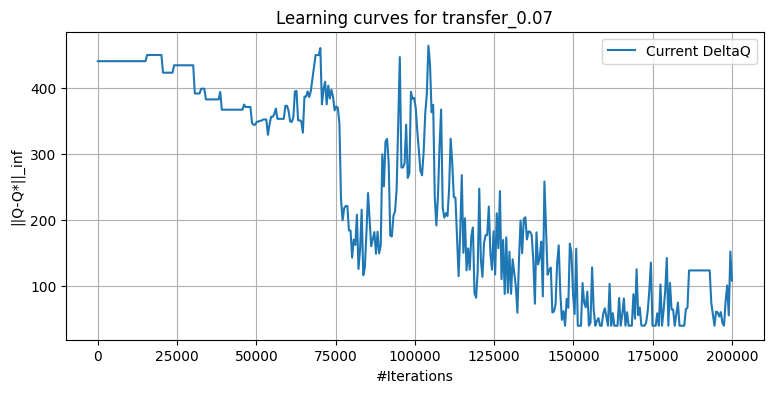

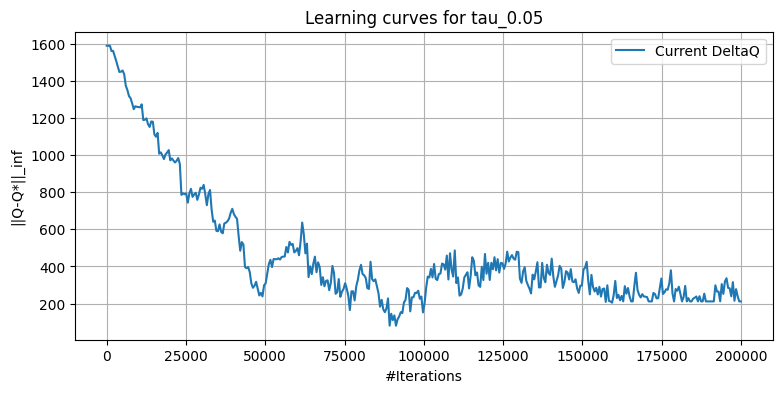

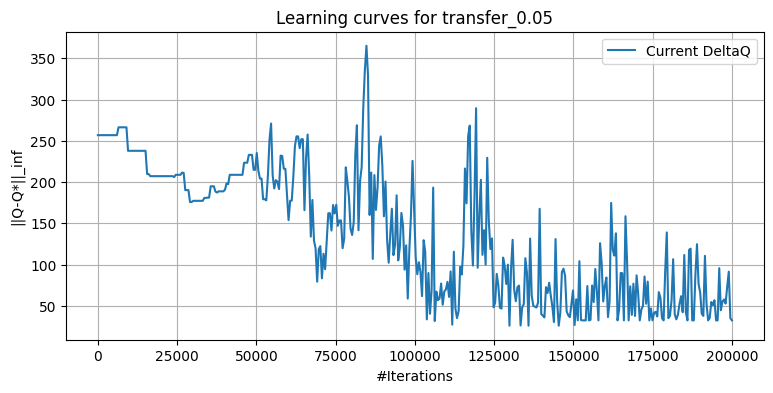

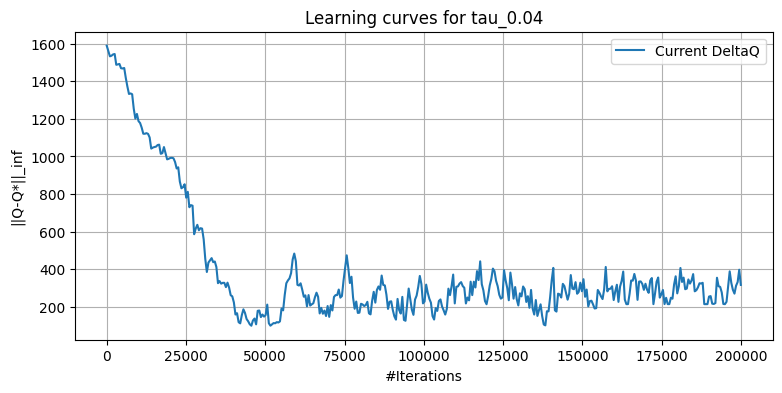

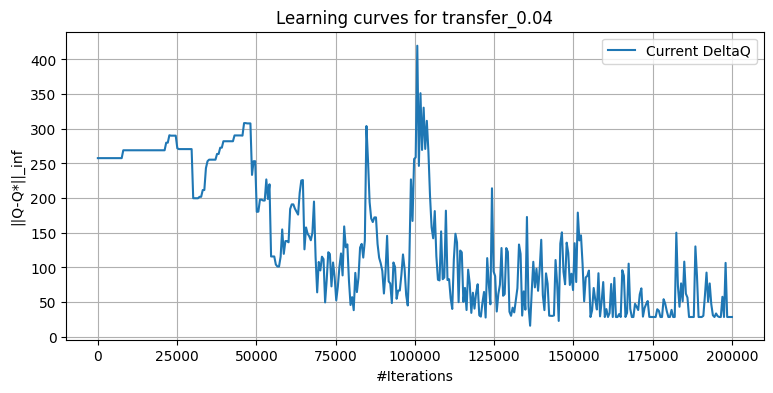

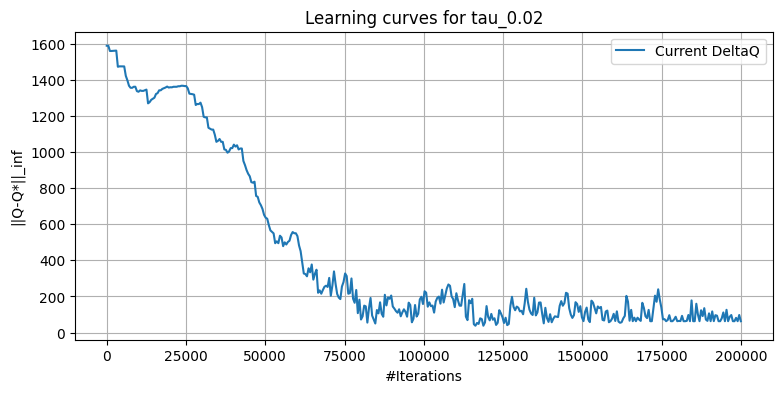

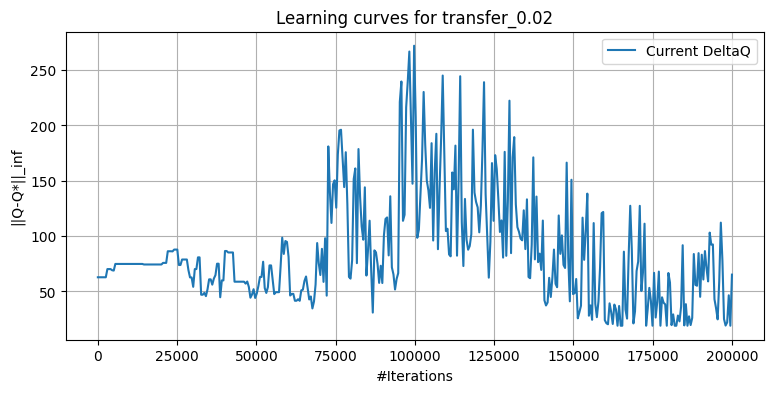

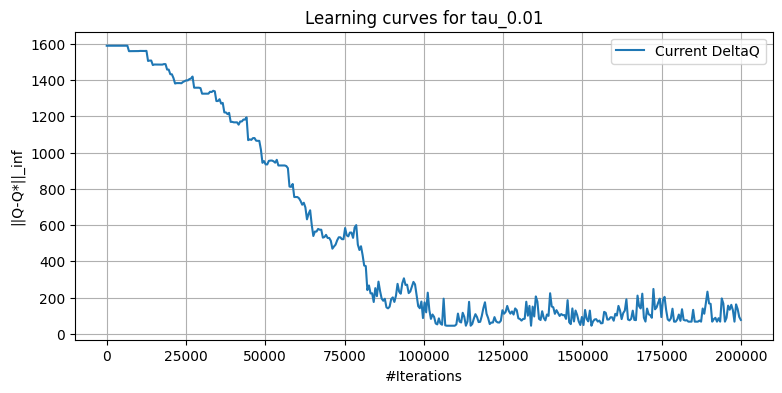

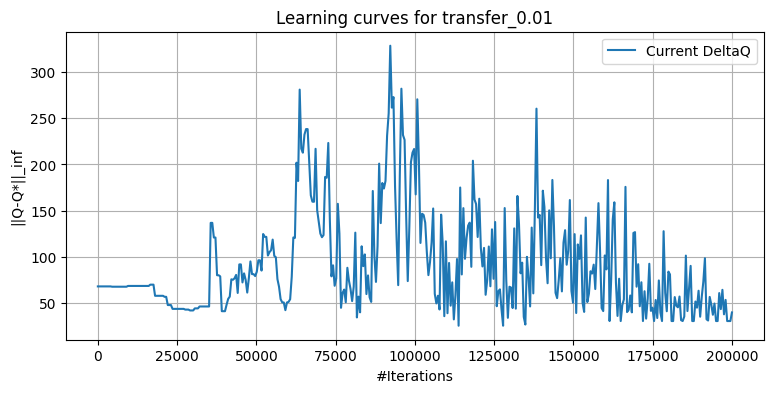

In [16]:
for i, key in enumerate(intermediate_results.keys()):
    xmax = len(intermediate_results[key]['delta_q'])*status_step
    x = np.linspace(0, xmax, num=len(intermediate_results[key]['delta_q']))
    y = intermediate_results[key]['delta_q']
    plt.figure(fignS=(9, 4))
    #plt.scatter(x, y, c='orange', label='Current DeltaQ')
    plt.plot(x, y, label='Current DeltaQ')
    plt.legend(loc="upper right")
    plt.xlabel('#Iterations')
    plt.ylabel('||Q-Q*||_inf')
    plt.grid(visible=True)
    plt.title('Learning curves for '+str(key))

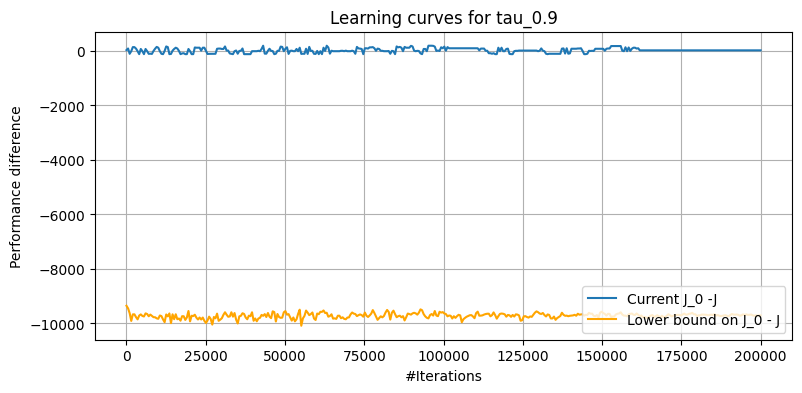

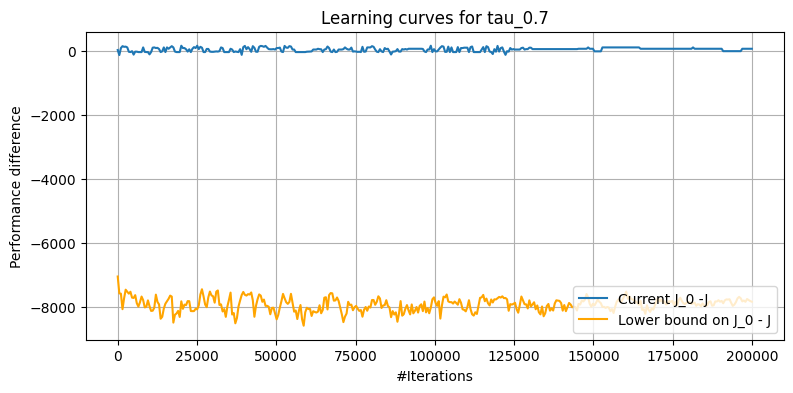

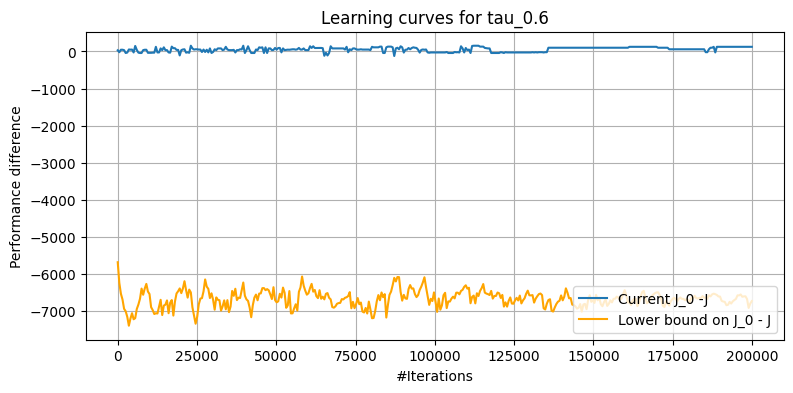

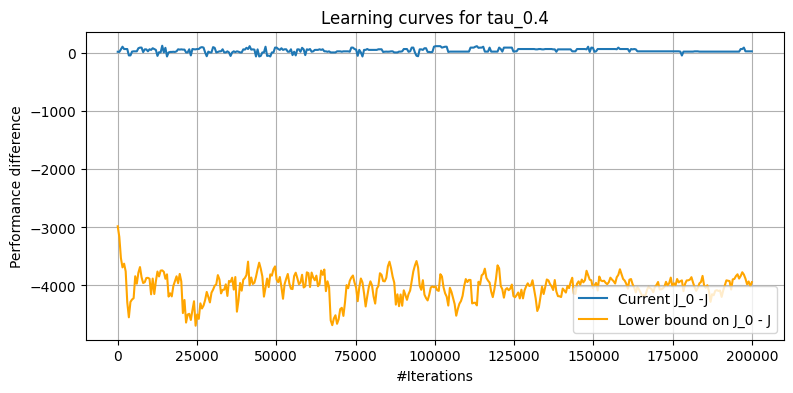

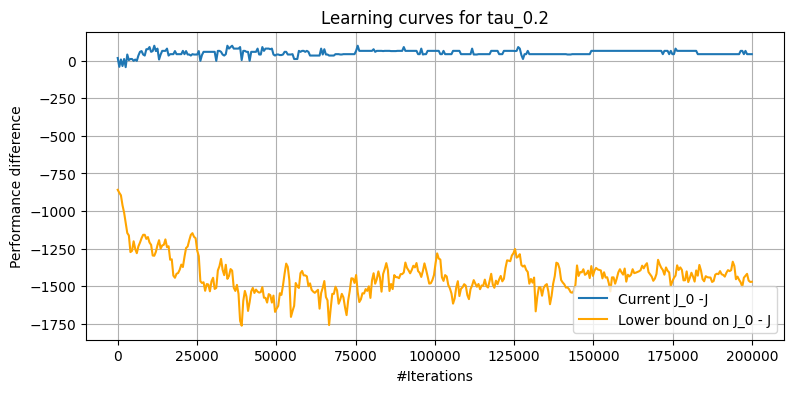

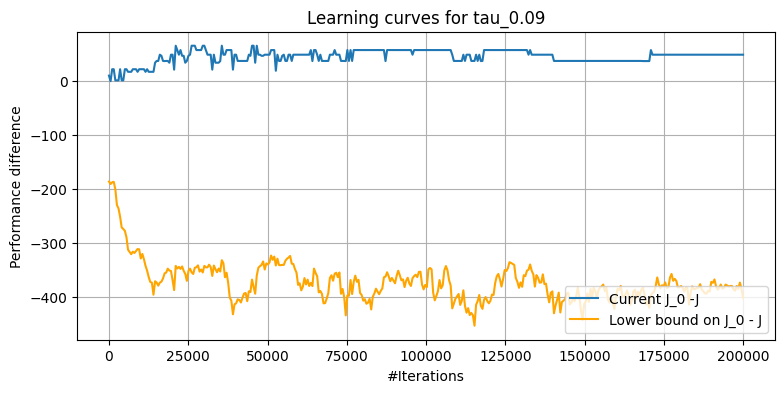

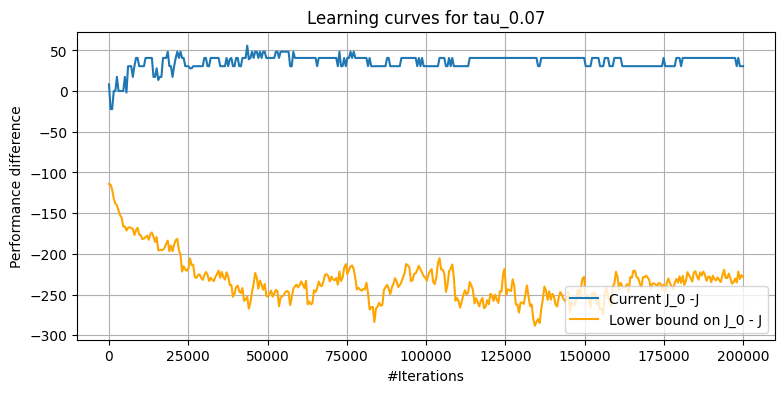

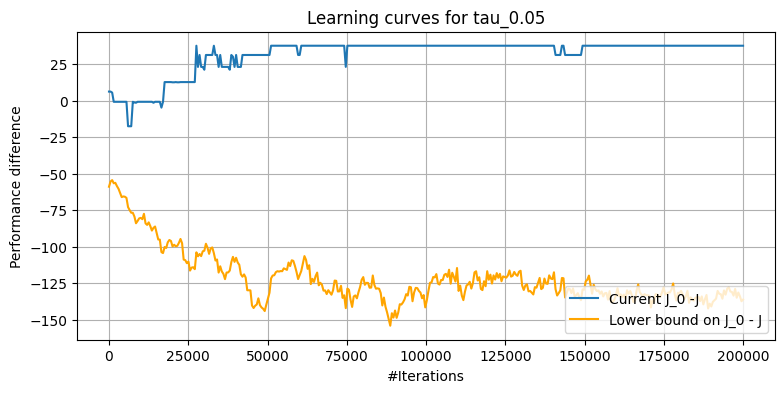

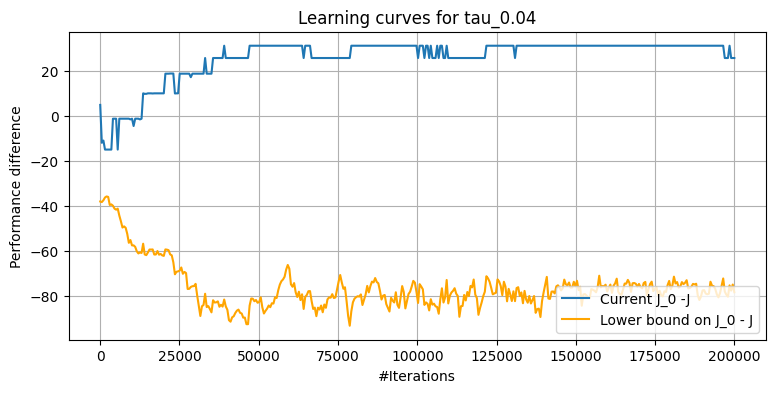

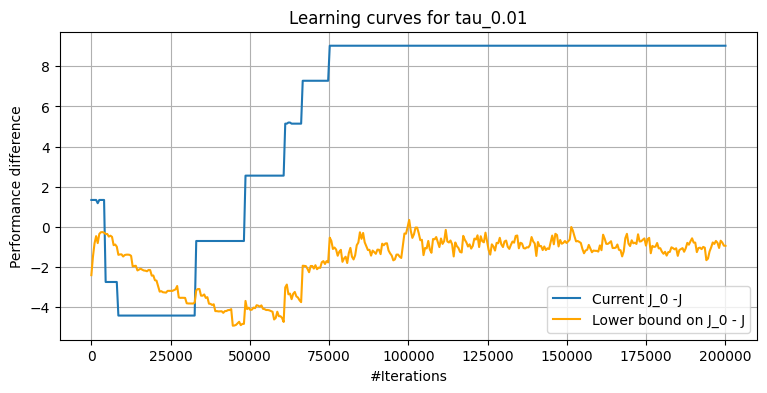

In [17]:
for i, key in enumerate(intermediate_results.keys()):
    if "tau_" in key:
        xmax = len(intermediate_results[key]['delta_J'])*status_step
        x = np.linspace(0, xmax, num=len(intermediate_results[key]['delta_J']))
        y = np.array(intermediate_results[key]['J_main_p']) - np.array(intermediate_results[key]['J_curr_p'])
        z = intermediate_results[key]['l_bounds']
        plt.figure(fignS=(9, 4))
        #plt.scatter(x, y, c='orange', label='Current J_0 -J')
        plt.plot(x, y, label='Current J_0 -J')

        #plt.scatter(x, z, c='blue', label='Lower bound on J_0 -J')
        plt.plot(x, z, c='orange', label='Lower bound on J_0 - J')

        plt.grid(visible=True)
        plt.legend(loc="lower right")
        plt.xlabel('#Iterations')
        plt.ylabel('Performance difference')
        plt.title('Learning curves for '+str(key))